# Looking at SKM-TEA Predictions

In [1]:
# Imports
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import os
import json
import pandas as pd
import torch

In [2]:
# Define Dice Coefficient for two masks
def dice_coefficient(mask1, mask2):
    intersection = torch.sum(mask1 * mask2)
    sum = mask1.sum().item() + mask2.sum().item()
    dice = (2.0 * intersection) / sum
    return dice.item()

In [74]:
# return menisci mask from path
def get_meniscus_mask(data_dir, filename):

    # Get full path to ground truth file
    full_gt_path = os.path.join(data_dir, filename)

    # Open the HDF5 file in read mode
    with h5py.File(full_gt_path, 'r') as hf:
        # Load segmentation data (One-hot encoded, 6 classes)
        seg = hf['seg'][:]

    # Get just meniscus mask
    # menisci
    med_mask = seg[...,4]

    lat_mask = seg[...,5]

    # combine
    minisc_mask = np.add(med_mask, lat_mask)

    return minisc_mask

## Get Image Paths

In [31]:
# Paths
image_dir_path = 'qdess/v1-release/image_files/'
ann_dir_path = 'qdess/v1-release/annotations/v1.0.0/'
pred_path = 'unet_mask_predictions_val'

In [4]:
# Path to the JSON file
file_path = "val.json"

# Open and load the JSON file
with open(ann_dir_path + file_path, "r") as file:
    data = json.load(file)

# Access each part of the JSON structure
info = data["info"]
categories = data["categories"]
images = data["images"]
annotations = data["annotations"]

# get paths from image data
ims_df = pd.DataFrame(images)
ims_df.head()

,id,file_name,msp_id,msp_file_name,scan_id,subject_id,timepoint,voxel_spacing,matrix_shape,orientation,num_echoes,inspected
0,1,MTR_013.h5,0000048_V00,0000048_V00.h5,MTR_013,48,0,"[0.3125, 0.3125, 0.8]","[512, 512, 160]","[SI, AP, LR]",2,True
1,2,MTR_023.h5,0000195_V00,0000195_V00.h5,MTR_023,195,0,"[0.3125, 0.3125, 0.8]","[512, 512, 160]","[SI, AP, LR]",2,True
2,3,MTR_026.h5,0000189_V00,0000189_V00.h5,MTR_026,189,0,"[0.3125, 0.3125, 0.8]","[512, 512, 160]","[SI, AP, LR]",2,True
3,4,MTR_037.h5,0000263_V00,0000263_V00.h5,MTR_037,263,0,"[0.3125, 0.3125, 0.8]","[512, 512, 160]","[SI, AP, LR]",2,True
4,5,MTR_038.h5,0000184_V00,0000184_V00.h5,MTR_038,184,0,"[0.3125, 0.3125, 0.8]","[512, 512, 160]","[SI, AP, LR]",2,True


In [5]:
len(ims_df)

33

In [6]:
# paths of all images in the split the json file refers to
image_paths = ims_df['file_name'].to_numpy()
print(image_paths[:5])

['MTR_013.h5' 'MTR_023.h5' 'MTR_026.h5' 'MTR_037.h5' 'MTR_038.h5']


In [9]:
# Mapping dictionaries for cross-referencing filename from imageid
id_to_filename = dict(zip(ims_df["id"], ims_df["file_name"]))

# pathology categories and ids

In [10]:
# as a dataframe
categories_df = pd.DataFrame(categories)

In [11]:
# notice category 1 is meniscal tear
categories_df

,supercategory,supercategory_id,id,name
0,Meniscal Tear,1,1,Meniscal Tear (Myxoid)
1,Meniscal Tear,1,2,Meniscal Tear (Horizontal)
2,Meniscal Tear,1,3,Meniscal Tear (Radial)
3,Meniscal Tear,1,4,Meniscal Tear (Vertical/Longitudinal)
4,Meniscal Tear,1,5,Meniscal Tear (Oblique)
5,Meniscal Tear,1,6,Meniscal Tear (Complex)
6,Meniscal Tear,1,7,Meniscal Tear (Flap)
7,Meniscal Tear,1,8,Meniscal Tear (Extrusion)
8,Ligament Tear,2,9,Ligament Tear (Low-Grade Sprain)
9,Ligament Tear,2,10,Ligament Tear (Moderate Grade Sprain or Mucoid...


In [12]:
# Mapping dictionaries for cross-referencing
id_to_name = dict(zip(categories_df["id"], categories_df["name"]))
id_to_supercategory = dict(zip(categories_df["id"], categories_df["supercategory"]))

In [13]:
id_to_name.get(1)

'Meniscal Tear (Myxoid)'

## Load and sort pathology annotations

In [14]:
annotations[0]

{'id': 1,
 'image_id': 19,
 'category_id': 16,
 'tissue_id': -1,
 'bbox': [88.0, 19.0, 38.0, 247.0, 240.0, 92.0],
 'confidence': 5.0,
 'labeler': 1}

In [15]:
anns_df = pd.DataFrame(annotations)

In [16]:
anns_df.head()

,id,image_id,category_id,tissue_id,bbox,confidence,labeler
0,1,19,16,-1,"[88.0, 19.0, 38.0, 247.0, 240.0, 92.0]",5.0,1
1,2,19,5,1,"[328.0, 295.0, 104.0, 6.0, 11.0, 12.0]",4.0,1
2,3,19,11,2,"[257.0, 245.0, 72.0, 40.0, 34.0, 16.0]",4.0,1
3,4,21,2,1,"[355.0, 208.0, 41.0, 12.0, 21.0, 15.0]",4.0,1
4,5,32,16,-1,"[5.0, 111.0, 66.0, 227.0, 103.0, 61.0]",4.0,1


In [17]:
# Look at tissue types (Note that meniscus is 1)
data['tissues']

[{'id': 1, 'name': 'Meniscus'},
 {'id': 2, 'name': 'ACL'},
 {'id': 3, 'name': 'PCL'},
 {'id': 4, 'name': 'Femoral Cartilage'},
 {'id': 5, 'name': 'Patellar Cartilage'},
 {'id': 6, 'name': 'Tibial Cartilage'}]

In [20]:
# filter by meniscus
menisc_anns_df = anns_df[anns_df['tissue_id'] == 1]
print(f'Number of meniscus annotations: {len(menisc_anns_df)}')
menisc_anns_df.head()

Number of meniscus annotations: 30


,id,image_id,category_id,tissue_id,bbox,confidence,labeler
1,2,19,5,1,"[328.0, 295.0, 104.0, 6.0, 11.0, 12.0]",4.0,1
3,4,21,2,1,"[355.0, 208.0, 41.0, 12.0, 21.0, 15.0]",4.0,1
5,6,32,2,1,"[305.0, 280.0, 45.0, 6.0, 7.0, 10.0]",2.0,1
9,10,4,5,1,"[293.0, 335.0, 110.0, 6.0, 22.0, 15.0]",3.0,1
14,15,14,8,1,"[305.0, 219.0, 89.0, 14.0, 54.0, 15.0]",4.0,1


In [21]:
# get list of image ids with meniscus pathology
pathology_im_ids = menisc_anns_df['image_id'].to_numpy()

In [22]:
pathology_im_ids

array([19, 21, 32,  4, 14, 14, 20, 20, 26, 30,  8, 10, 10, 15, 15, 15, 27,
       27, 27, 29, 29, 29,  2,  2,  6,  6,  6, 23, 25,  7])

In [23]:
# list of all image ids
all_ims = ims_df['id'].to_numpy()

In [24]:
all_ims

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [25]:
# Initialise a DataFrame with image IDs and zero counts
pathology_count_df = pd.DataFrame({'image_id': all_ims, 'num_pathologies': 0})

# Add count to image for each pathology found in the pathology list
for pid in pathology_im_ids:
    if pid in pathology_count_df['image_id'].values:
        pathology_count_df.loc[pathology_count_df['image_id'] == pid, 'num_pathologies'] += 1

In [27]:
pathology_count_df.head()

,image_id,num_pathologies
0,1,0
1,2,2
2,3,0
3,4,1
4,5,0


# For each path, load seg GT and prediction to get dice score

In [37]:
# Loop through paths, load segmentation ground truth and prediction, calculate dice coefficient
dice_scores = []
for im_id in all_ims:
    # Get the filename
    filename = id_to_filename[im_id]

    # Load the ground truth mask
    menisc_mask = get_meniscus_mask(image_dir_path, filename)

    # Load the prediction mask
    # first take off .h5 extension and add .npy
    filename = filename[:-3] + '.npy'
    full_pred_path = os.path.join(pred_path, filename)
    pred_mask = np.load(full_pred_path)

    # Calculate the dice coefficient
    dice = dice_coefficient(torch.tensor(menisc_mask), torch.tensor(pred_mask))

    # Append to list
    dice_scores.append(dice)

    print(dice)

print(f"Mean Dice Coefficient: {np.mean(dice_scores)}")

# Add dice scores to pathology_count_df
pathology_count_df['dice'] = dice_scores

0.7795218229293823
0.7524562478065491
0.7227641344070435
0.8031360507011414
0.7568774223327637
0.6654624342918396
0.7282947301864624
0.7841781377792358
0.7362043261528015
0.652190625667572
0.7848562002182007
0.6789541244506836
0.63204026222229
0.7975828051567078
0.7734728455543518
0.8035393953323364
0.7650856375694275
0.6800203919410706
0.7754375338554382
0.7354987263679504
0.7621867060661316
0.7879033088684082
0.7790279984474182
0.7045125365257263
0.7585326433181763
0.7566063404083252
0.7067292928695679
0.7187729477882385
0.7185410261154175
0.7300627827644348
0.6538073420524597
0.7118544578552246
0.7674567103385925
Mean Dice Coefficient: 0.7382899378285264


In [38]:
pathology_count_df.head()

,image_id,num_pathologies,dice
0,1,0,0.779522
1,2,2,0.752456
2,3,0,0.722764
3,4,1,0.803136
4,5,0,0.756877


In [39]:
ims_with_pathology = pathology_count_df[pathology_count_df['num_pathologies'] > 0].reset_index(drop=True)
ims_without_pathology = pathology_count_df[pathology_count_df['num_pathologies'] == 0].reset_index(drop=True)

In [43]:
print("All Images with Pathology:")
ims_with_pathology

All Images with Pathology:


,image_id,num_pathologies,dice
0,2,2,0.752456
1,4,1,0.803136
2,6,3,0.665462
3,7,1,0.728295
4,8,1,0.784178
5,10,2,0.652191
6,14,2,0.797583
7,15,3,0.773473
8,19,1,0.775438
9,20,2,0.735499


In [44]:
print("All Images without Pathology:")
ims_without_pathology

All Images without Pathology:


,image_id,num_pathologies,dice
0,1,0,0.779522
1,3,0,0.722764
2,5,0,0.756877
3,9,0,0.736204
4,11,0,0.784856
5,12,0,0.678954
6,13,0,0.632040
7,16,0,0.803539
8,17,0,0.765086
9,18,0,0.680020


In [46]:
# Get mean and std of dice scores for images with pathology
mean_dice_pathology = ims_with_pathology['dice'].mean()
std_dice_pathology = ims_with_pathology['dice'].std()
print(f"Mean Dice Coefficient for Images with Pathology: {mean_dice_pathology} ± {std_dice_pathology}")

# Get mean and std of dice scores for images without pathology
mean_dice_no_pathology = ims_without_pathology['dice'].mean()
std_dice_no_pathology = ims_without_pathology['dice'].std()
print(f"Mean Dice Coefficient for Images without Pathology: {mean_dice_no_pathology} ± {std_dice_no_pathology}")

Mean Dice Coefficient for Images with Pathology: 0.7439584102895525 ± 0.0420221477759853
Mean Dice Coefficient for Images without Pathology: 0.731487770875295 ± 0.05272383128592712


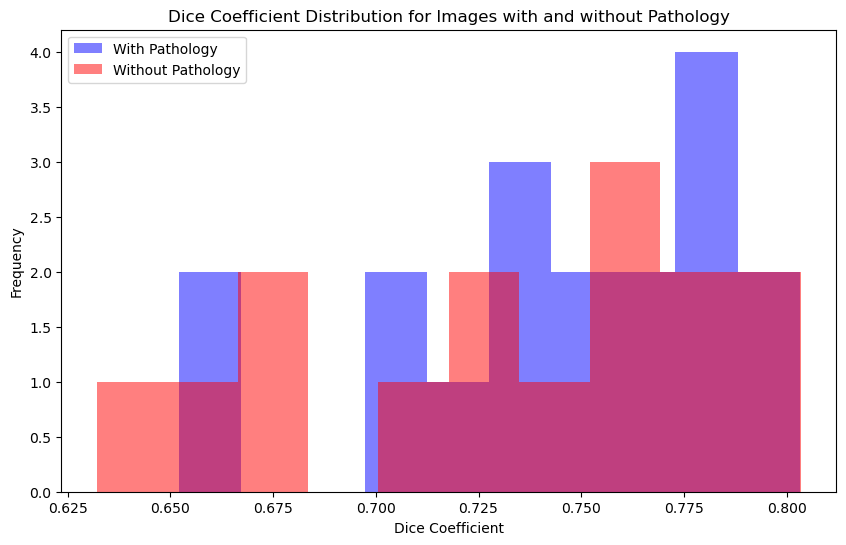

In [53]:
# Plot histograms of dice scores with and without pathology for comparison
plt.figure(figsize=(10, 6))
plt.hist(ims_with_pathology['dice'], bins=10, alpha=0.5, color='blue', label='With Pathology')
plt.hist(ims_without_pathology['dice'], bins=10, alpha=0.5, color='red', label='Without Pathology')
plt.xlabel('Dice Coefficient')
plt.ylabel('Frequency')
plt.title('Dice Coefficient Distribution for Images with and without Pathology')
plt.legend()
plt.show()

/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


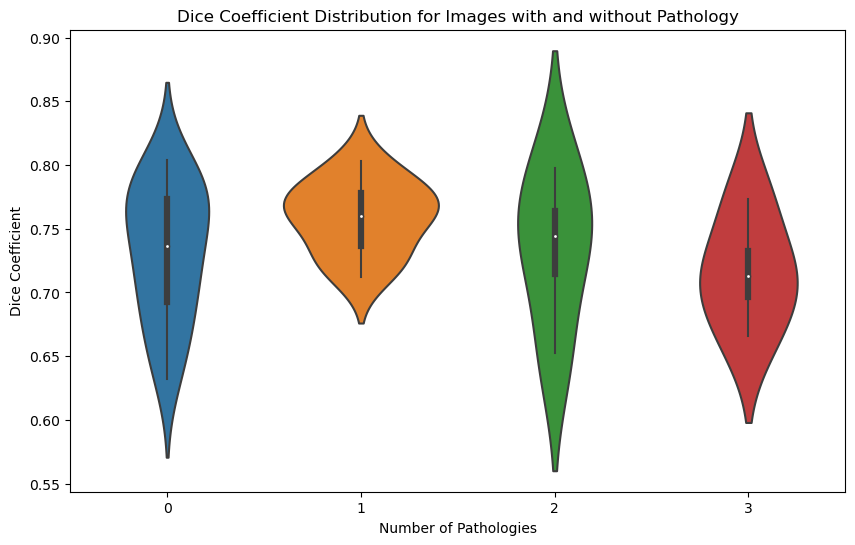

In [58]:
# plot violin plots of with and without pathology using seaborn
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.violinplot(data=pathology_count_df, x='num_pathologies', y='dice')
plt.xlabel('Number of Pathologies')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficient Distribution for Images with and without Pathology')

# save plot
plt.savefig('dice_vs_pathology_valid.png')
plt.show()

In [69]:
# check dice scores to see if they are consistent statistically
# use t-test for this
from scipy.stats import ttest_ind, mannwhitneyu

t_stat, p_val = ttest_ind(ims_with_pathology['dice'], ims_without_pathology['dice'], equal_var=False)
print(f"t-statistic: {t_stat}, p-value: {p_val}")

# Mann-Whitney U test
u_stat, p_val = mannwhitneyu(ims_with_pathology['dice'], ims_without_pathology['dice'])
print(f"U-statistic: {u_stat}, p-value: {p_val}")

t-statistic: 0.7407484661060189, p-value: 0.46533378995890673
U-statistic: 146.0, p-value: 0.7042213495481418


### No meaningful difference in dice scores 

# Now look at region of ground truth that contains pathology

In [73]:
# pick first annotation as example
example = menisc_anns_df.iloc[0]
example

id                                                  2
image_id                                           19
category_id                                         5
tissue_id                                           1
bbox           [328.0, 295.0, 104.0, 6.0, 11.0, 12.0]
confidence                                        4.0
labeler                                             1
Name: 1, dtype: object

In [75]:
example_im_id = example['image_id']
x_min, y_min, z_min, width, height, depth = example['bbox']

example_gt_mask = get_meniscus_mask(image_dir_path, id_to_filename[example_im_id])
example_pred_mask = np.load(os.path.join(pred_path, id_to_filename[example_im_id][:-3] + '.npy'))

In [ ]:
# plot the masks side by side within the bounding box region, where slice is taken from the middle
slicenum = z_min + depth // 2

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the ground truth mask
ax[0].imshow(example_gt_mask[x_min:x_min+width, y_min:y_min+height, slicenum], cmap='gray')
ax[0].set_title('Ground Truth')

# Plot the prediction mask
ax[1].imshow(example_pred_mask[z_min, y_min:y_min+height, x_min:x_min+width, slicenum], cmap='gray')
ax[1].set_title('Prediction')


# 